In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.neural_network import MLPClassifier
#from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import classification_report,confusion_matrix

import tensorflow
from tensorflow import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers import Dense, Embedding, LSTM
from keras.utils import np_utils
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.initializers import RandomNormal, Constant

from scipy.io import wavfile
import librosa
import librosa.display
from IPython.display import Audio
import soundfile
from pydub import AudioSegment

import nlpaug
nlpaug.__version__
import nlpaug.augmenter.audio as naa
from nlpaug.util.audio.visualizer import AudioVisualizer

import os, glob, pickle
import struct

import warnings
warnings.filterwarnings('ignore')

In [ ]:
os.getcwd()

'/Users/michelleyuu/Desktop/data255/project/archive'

In [ ]:
os.chdir('/Users/michelleyuu/Desktop/data255/project/archive')


In [ ]:
os.chdir('/Users/michelleyuu/Desktop/data255/project/archive/Tess')
dir_path = '/Users/michelleyuu/Desktop/data255/project/archive/Tess'

In [ ]:
#Emotion dictionary for RAVDESS dataset

emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

In [ ]:
def extract_feature(file_name, mfcc, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype = "float32")
        X = noise(X) # data augmentation 
        sample_rate = sound_file.samplerate
        result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y = X, sr = sample_rate, n_mfcc = 30).T, axis = 0)
            result = np.hstack((result, mfccs))
        
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
    return result

In [ ]:
paths = []
labels = []
for dirname, _, filenames in os.walk(dir_path):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
    if len(paths) == 2800:
        break
print('Dataset is Loaded')

Dataset is Loaded


In [ ]:
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,/Users/michelleyuu/Desktop/data255/project/arc...,disgust
1,/Users/michelleyuu/Desktop/data255/project/arc...,disgust
2,/Users/michelleyuu/Desktop/data255/project/arc...,disgust
3,/Users/michelleyuu/Desktop/data255/project/arc...,disgust
4,/Users/michelleyuu/Desktop/data255/project/arc...,disgust


In [ ]:
df['label'].value_counts()

fear       400
disgust    400
happy      400
angry      400
sad        400
ps         400
neutral    400
Name: label, dtype: int64

In [ ]:
os.chdir('/Users/michelleyuu/Desktop/data255/project/archive/Ravdess/audio_speech_actors_01-24')
dir_path = '/Users/michelleyuu/Desktop/data255/project/archive/Ravdess/audio_speech_actors_01-24'

audios = glob.glob(os.path.join("Actor_*/*.wav"), recursive=True)


In [ ]:
emotion=[emotions[i.split("-")[2]] for i in audios]
data_tuples = list(zip(audios,emotion))
metadata = pd.DataFrame(data_tuples, columns=['speech','label'])

In [ ]:
metadata.head()

,speech,label
0,Actor_16/03-01-05-01-02-01-16.wav,angry
1,Actor_16/03-01-06-01-02-02-16.wav,fearful
2,Actor_16/03-01-06-02-01-02-16.wav,fearful
3,Actor_16/03-01-05-02-01-01-16.wav,angry
4,Actor_16/03-01-07-01-01-01-16.wav,disgust


In [ ]:
frames = [df, metadata]

result = pd.concat(frames,ignore_index=True)

<AxesSubplot:xlabel='label', ylabel='count'>

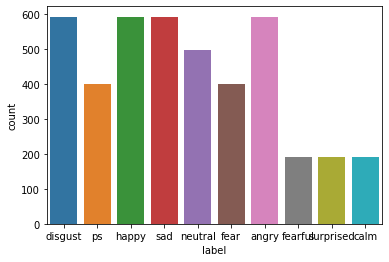

In [ ]:
sns.countplot(result['label'])

In [ ]:
result['label']=result['label'].replace("ps","surprised")
result['label']=result['label'].replace("neutral","calm")
result['label']=result['label'].replace("fearful","fear")

<AxesSubplot:xlabel='label', ylabel='count'>

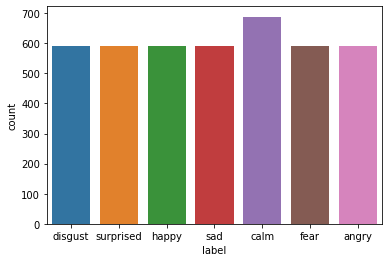

In [ ]:
sns.countplot(result['label'])

In [ ]:
df=result

In [ ]:
def extract_mfcc(filename):
        
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc

In [ ]:
def noise(filename):
    aug = naa.NoiseAug()
    
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    
    augmented_data = aug.augment(y)
    
    mfcc = np.mean(librosa.feature.mfcc(y=augmented_data, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc

In [ ]:
def pitch(filename):
     
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    
    aug = naa.PitchAug(sampling_rate=sr, factor=(2,3))
    augmented_data = aug.augment(y)
    mfcc = np.mean(librosa.feature.mfcc(y=augmented_data, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc

In [ ]:
X_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))

In [ ]:
X_noise= df['speech'].apply(lambda x: noise(x))

In [ ]:
X_pitch= df['speech'].apply(lambda x: pitch(x))

In [ ]:
X_con1=pd.concat([X_mfcc, X_noise, X_pitch], ignore_index=True)

In [ ]:
X_con1.to_csv (r'mfcc_comb_noise_pitch.csv', header=False) 

In [ ]:
X_con1 = pd.read_csv('mfcc_comb_noise_pitch.csv')

In [ ]:
print(X_con1.shape)
X = [x for x in X_con1]
print(X_con1.shape)
X = np.array(X)

X.shape

(12720,)
(12720,)


(12720, 40)

In [ ]:
## input split
X_1 = np.expand_dims(X, -1)
X_1.shape

(1, 1)

In [ ]:
#Apply Standardization

scaler = StandardScaler()
min_max_scaler = preprocessing.MinMaxScaler(feature_range = (0,1))

X_s = scaler.fit_transform(X)

## input split
#X_1 = np.expand_dims(X_s, -1)

enc = OneHotEncoder()
y = enc.fit_transform(df[['label']])
y = y.toarray()

In [ ]:
y1=np.concatenate((y, y,y), axis=0)

In [ ]:
y.shape, X.shape, y1.shape, X_1.shape

((4240, 7), (12720, 40), (12720, 7), (12720, 40, 1))

In [ ]:
#Split data into training and testing

x_train,x_test,y_train,y_test=train_test_split(np.array(X), y1, test_size=0.25, random_state=42)

In [ ]:
x_train.shape, y_train.shape

((9540, 40), (9540, 10))

In [ ]:
#Apply MLP classifier model

tensorflow.keras.backend.clear_session()

mlp=MLPClassifier(solver='adam', batch_size=64, 
                  hidden_layer_sizes= (400, 350, 300, 250, 200, 150, 100, 50), 
                  activation = 'relu', 
                  learning_rate='adaptive', 
                  learning_rate_init=0.003, 
                  max_iter=500, 
                  verbose = 1)

In [ ]:
# Train the model
mlp.fit(x_train,y_train)

# Predict for the test set
y_pred=mlp.predict(x_test)

Iteration 1, loss = 3.00178163
Iteration 2, loss = 1.52042390
Iteration 3, loss = 1.31851482
Iteration 4, loss = 1.12509921
Iteration 5, loss = 1.06714523
Iteration 6, loss = 1.04809104
Iteration 7, loss = 1.00537163
Iteration 8, loss = 0.99029372
Iteration 9, loss = 0.96027188
Iteration 10, loss = 0.94223847
Iteration 11, loss = 0.94003186
Iteration 12, loss = 0.94407019
Iteration 13, loss = 0.88827006
Iteration 14, loss = 0.88680309
Iteration 15, loss = 0.89231982
Iteration 16, loss = 0.86202459
Iteration 17, loss = 0.83770918
Iteration 18, loss = 0.83942551
Iteration 19, loss = 0.85014434
Iteration 20, loss = 0.82846905
Iteration 21, loss = 0.79120801
Iteration 22, loss = 0.87026093
Iteration 23, loss = 0.86792487
Iteration 24, loss = 0.94027377
Iteration 25, loss = 0.77828803
Iteration 26, loss = 0.77251414
Iteration 27, loss = 0.75434242
Iteration 28, loss = 0.75976757
Iteration 29, loss = 0.76547397
Iteration 30, loss = 0.74686645
Iteration 31, loss = 0.70573382
Iteration 32, los

In [ ]:
# Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)

# Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 79.03%


Accuracy: 0.79
              precision    recall  f1-score   support

           0       0.96      0.84      0.89       496
           1       0.67      0.53      0.59       139
           2       0.87      0.89      0.88       434
           3       0.99      1.00      1.00       275
           4       0.69      0.48      0.57       151
           5       0.92      0.76      0.83       435
           6       0.99      0.80      0.88       373
           7       0.98      0.93      0.96       287
           8       0.88      0.76      0.82       443
           9       0.69      0.43      0.53       147

   micro avg       0.91      0.79      0.85      3180
   macro avg       0.86      0.74      0.79      3180
weighted avg       0.90      0.79      0.84      3180
 samples avg       0.79      0.79      0.79      3180



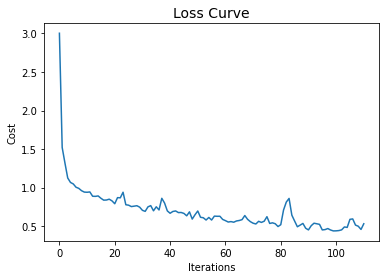

In [ ]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report
 
y_pred = mlp.predict(x_test)
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred)) 

# Loss curve
plt.plot(mlp.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

In [ ]:
#Create Earlystopping and Learning Rate functions

earlystopping = EarlyStopping(monitor ="val_acc",
                              mode = 'max', 
                              patience = 10,
                              verbose = 1,
                              restore_best_weights = True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=10,
                                            verbose=1,
                                            factor=0.05,
                                            min_lr=0.00001)

rp = keras.callbacks.ReduceLROnPlateau(
        monitor="val_acc",
        factor=0.2,
        patience=3,
        verbose=1,
        mode="max",
        min_lr=0.00001,
     )

In [ ]:
#Create CNN architecture using funnel method and Convolution and Maxpooling, 
# BatchNormalization worsened the performance, so it was removed

tensorflow.keras.backend.clear_session()

model = models.Sequential() 
model.add(Conv1D(filters = 64, kernel_size = 8, padding = 'same', input_shape=(x_train.shape[1],1)))
#model.add(BatchNormalization())

model.add(layers.ZeroPadding1D(padding = 1))
model.add(MaxPooling1D(pool_size=2, padding='same', strides = 1))

model.add(Conv1D(filters = 64, kernel_size = 8, padding = 'same', activation="relu"))
#model.add(BatchNormalization())

model.add(layers.ZeroPadding1D(padding = 1))
model.add(MaxPooling1D(pool_size=2, padding='same', strides = 1))

model.add(Conv1D(filters = 128, kernel_size = 8, padding = 'same', activation="relu"))
#model.add(BatchNormalization())

model.add(layers.ZeroPadding1D(padding = 1))
model.add(MaxPooling1D(pool_size=2, padding='same', strides = 1))

model.add(Conv1D(filters = 128, kernel_size = 8, padding = 'same', activation="relu"))
#model.add(BatchNormalization())

model.add(layers.ZeroPadding1D(padding = 1))
model.add(MaxPooling1D(pool_size=2, padding='same', strides = 1))

model.add(Dropout(0.50))

model.add(Flatten())

model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.10))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.10))
model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.10))
model.add(Dense(32, activation = "relu"))

model.add(BatchNormalization(momentum=0.975, 
                             epsilon=0.005, 
                             beta_initializer=RandomNormal(mean=0.0, stddev=0.05), 
                             gamma_initializer=Constant(value=0.975)))

model.add(layers.Dense(y.shape[1], activation="softmax"))

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"]) #rmsprop
model.summary() 

#traditional machine learning methods - classification
#number of layers/neruons

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 64)            576       
                                                                 
 zero_padding1d (ZeroPadding  (None, 42, 64)           0         
 1D)                                                             
                                                                 
 max_pooling1d (MaxPooling1D  (None, 42, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 42, 64)            32832     
                                                                 
 zero_padding1d_1 (ZeroPaddi  (None, 44, 64)           0         
 ng1D)                                                           
                                                        

In [ ]:
EPOCHS = 100
batch_size = 64

history = model.fit(x_train, y_train, validation_split=0.2,
                    epochs=EPOCHS, batch_size=batch_size,
                    callbacks=[earlystopping, learning_rate_reduction])

Epoch 1/100
120/120 [==============================] - 9s 62ms/step - loss: 1.7824 - acc: 0.3933 - val_loss: 1.3188 - val_acc: 0.5419 - lr: 0.0010
Epoch 2/100
120/120 [==============================] - 7s 62ms/step - loss: 1.2596 - acc: 0.5677 - val_loss: 1.0864 - val_acc: 0.6064 - lr: 0.0010
Epoch 3/100
120/120 [==============================] - 8s 63ms/step - loss: 1.0160 - acc: 0.6524 - val_loss: 0.9333 - val_acc: 0.6656 - lr: 0.0010
Epoch 4/100
120/120 [==============================] - 8s 66ms/step - loss: 0.8544 - acc: 0.7003 - val_loss: 0.7792 - val_acc: 0.7186 - lr: 0.0010
Epoch 5/100
120/120 [==============================] - 8s 63ms/step - loss: 0.7886 - acc: 0.7231 - val_loss: 0.7410 - val_acc: 0.7437 - lr: 0.0010
Epoch 6/100
120/120 [==============================] - 8s 64ms/step - loss: 0.7323 - acc: 0.7374 - val_loss: 0.7112 - val_acc: 0.7505 - lr: 0.0010
Epoch 7/100
120/120 [==============================] - 8s 70ms/step - loss: 0.7042 - acc: 0.7474 - val_loss: 0.6615 - 

100/100 [==============================] - 1s 10ms/step - loss: 0.5549 - acc: 0.8689
Accuracy of our CNN model on Validation data :  86.88679337501526 %


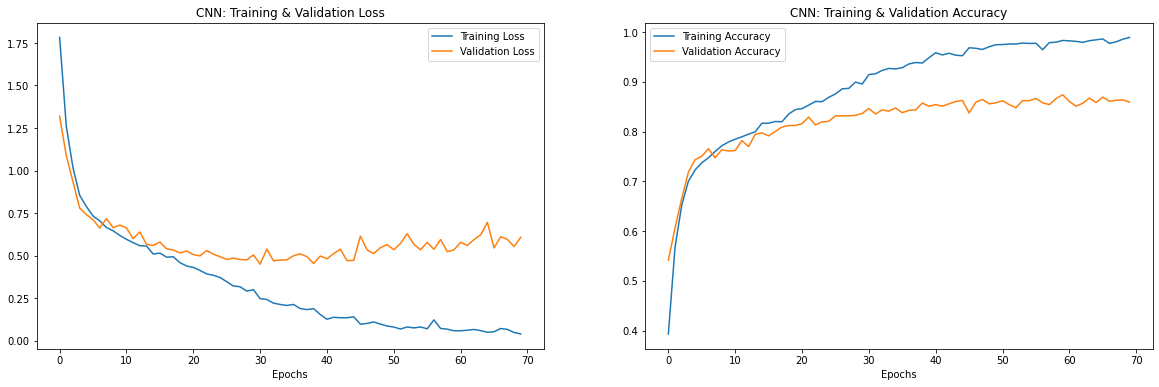

In [ ]:
print("Accuracy of our CNN model on Validation data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
test_acc = history.history['val_acc']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(train_loss, label = 'Training Loss')
ax[0].plot(test_loss , label = 'Validation Loss')
ax[0].set_title('CNN: Training & Validation Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(train_acc, label = 'Training Accuracy')
ax[1].plot(test_acc , label = 'Validation Accuracy')
ax[1].set_title('CNN: Training & Validation Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

##Add CNN title

In [ ]:
# Predict for the test set
y_pred=model.predict(x_test)

In [ ]:
# Calculate the accuracy of our model

accuracy=accuracy_score(y_true=np.argmax(y_test, axis=1), y_pred=np.argmax(y_pred, axis=1))

# Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 86.89%


In [ ]:
x_train_1,x_test_1,y_train_1,y_test_1 = train_test_split(np.array(X_1), y1, test_size=0.25, random_state=42)

In [ ]:
#LSTM Architecture

tensorflow.keras.backend.clear_session()

lstm = models.Sequential() 
lstm.add(LSTM(512, input_shape=(x_train_1.shape[1], 1), return_sequences = True, recurrent_dropout=0.20))
lstm.add(BatchNormalization())

lstm.add(LSTM(256, return_sequences = False, dropout = .50, recurrent_dropout=0.20))
lstm.add(Dropout(0.5))

lstm.add(Dense(256, activation = "relu"))
lstm.add(BatchNormalization())
lstm.add(Dropout(0.2))

lstm.add(Dense(128, activation = "relu"))
lstm.add(BatchNormalization())
lstm.add(Dropout(0.2))

lstm.add(Dense(64, activation = "relu"))
lstm.add(BatchNormalization())
lstm.add(Dropout(0.2))

lstm.add(layers.Dense(y1.shape[1], activation="softmax"))

lstm.summary() 

lstm.compile(loss='categorical_crossentropy', optimizer='Adamax', metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 512)           1052672   
                                                                 
 batch_normalization (BatchN  (None, 40, 512)          2048      
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                        

In [ ]:
earlystopping_lstm = EarlyStopping(monitor ="val_loss",
                              mode = 'max', patience = 10, verbose = 1,
                              restore_best_weights = True)

learning_rate_reduction_lstm = ReduceLROnPlateau(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            factor=0.05,
                                            min_lr=0.00001)

In [ ]:
EPOCHS = 50
batch_size = 64

history = lstm.fit(x_train_1, y_train_1, validation_data=(x_test_1, y_test_1),
                    epochs=EPOCHS, batch_size=batch_size)
#                    callbacks=[earlystopping_lstm, learning_rate_reduction_lstm])

Epoch 1/50
150/150 [==============================] - 114s 719ms/step - loss: 1.7969 - accuracy: 0.3635 - val_loss: 1.3495 - val_accuracy: 0.4701
Epoch 2/50
150/150 [==============================] - 107s 711ms/step - loss: 1.3469 - accuracy: 0.4962 - val_loss: 1.0813 - val_accuracy: 0.5937
Epoch 3/50
150/150 [==============================] - 104s 692ms/step - loss: 1.2066 - accuracy: 0.5476 - val_loss: 0.9804 - val_accuracy: 0.6314
Epoch 4/50
150/150 [==============================] - 103s 684ms/step - loss: 1.1311 - accuracy: 0.5931 - val_loss: 0.9353 - val_accuracy: 0.6686
Epoch 5/50
150/150 [==============================] - 102s 678ms/step - loss: 1.0667 - accuracy: 0.6117 - val_loss: 0.9042 - val_accuracy: 0.6745
Epoch 6/50
150/150 [==============================] - 101s 676ms/step - loss: 1.0163 - accuracy: 0.6355 - val_loss: 0.8616 - val_accuracy: 0.6862
Epoch 7/50
150/150 [==============================] - 102s 679ms/step - loss: 0.9818 - accuracy: 0.6563 - val_loss: 0.8381 -

100/100 [==============================] - 13s 134ms/step - loss: 0.5041 - accuracy: 0.8132
Accuracy of our LSTM model on test data :  81.32075667381287 %


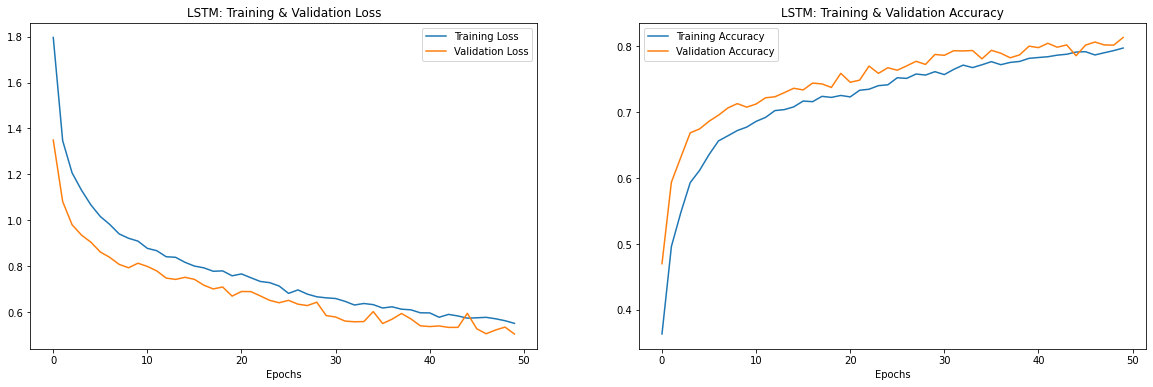

In [ ]:
print("Accuracy of our LSTM model on test data : " , lstm.evaluate(x_test_1,y_test_1)[1]*100 , "%")

fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(train_loss, label = 'Training Loss')
ax[0].plot(test_loss , label = 'Validation Loss')
ax[0].set_title('LSTM: Training & Validation Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(train_acc, label = 'Training Accuracy')
ax[1].plot(test_acc , label = 'Validation Accuracy')
ax[1].set_title('LSTM: Training & Validation Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

Extra

In [ ]:
tensorflow.keras.backend.clear_session()

model = models.Sequential() 
model.add(Conv1D(filters = 64, kernel_size = 4, padding = 'same', activation="relu", input_shape=(x_train.shape[1],1)))

model.add(Conv1D(filters = 64, kernel_size = 4, padding = 'same', activation="relu"))

#model.add(BatchNormalization(renorm=True))
#model.add(layers.ZeroPadding1D(padding = 1))

model.add(Dropout(0.50))

model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(128, activation = "relu"))

model.add(Dense(64, activation = "relu"))

#model.add(Dropout(0.20))

model.add(layers.Dense(y.shape[1], activation="softmax"))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["acc"]) #rmsprop
model.summary() 

#traditional machine learning methods - classification
#number of layers/neruons